In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import os # need for file enumeration
# import pickle
from sklearn.model_selection import train_test_split, GridSearchCV


# CNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications.vgg19 import preprocess_input


from tensorflow.keras import utils,losses
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

# some more image preprocessing
from tensorflow.keras.layers import RandomBrightness, RandomContrast, RandomCrop, RandomFlip
from tensorflow.keras.layers import RandomHeight, RandomRotation, RandomTranslation
from tensorflow.keras.layers import RandomWidth, RandomZoom
import skimage
import cv2
from PIL.ExifTags import TAGS
from PIL import ExifTags
from PIL import Image
from skimage.color import rgb2hsv

from os import listdir
from os.path import isfile, join


# pre-trained
from tensorflow.keras.applications import MobileNetV2,MobileNet,VGG19
from tensorflow.keras.applications import EfficientNetB7

import universal_methods
import importlib
importlib.reload(universal_methods)
from universal_methods import Universal


# metrics
from sklearn.metrics import plot_confusion_matrix,ConfusionMatrixDisplay, confusion_matrix

# For reproducibility
seed = 42
np.random.seed(seed)
# random.seed(seed)
tf.random.set_seed(seed)

/Users/glebradchenko/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class_labels=["Fake", "True"]

In [3]:
X,y=Universal().get_images()

Found 2041 images belonging to 2 classes.


In [4]:
# X,y,class_labels=Universal().get_images_multiclass()

In [5]:
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,stratify=y)
X_train.shape,y_train.shape, X_test.shape,y_test.shape

((1530, 600, 600, 3), (1530,), (511, 600, 600, 3), (511,))

____



In [16]:
from mtcnn import MTCNN

ModuleNotFoundError: No module named 'mtcnn'

In [32]:
#import mtcnn
from mtcnn.mtcnn import MTCNN


#create a detector
detector = MTCNN()
#detect face in a single image
def detect_face(path):
    read_image = cv2.imread(path)
    image=cv2.cvtColor(read_image,cv2.COLOR_BGR2RGB) 
    
    
    image=np.array(image)
    #detect faces in the image
    result=detector.detect_faces(image)
    #if no face is detected return an empty list
    if len(result)==0:
        return []
    #extract the bounding box of the face
    x1,y1,width,height=result[0]['box']
    #extract the face
    x1,y1,width,height=x1,y1,width,height
    face=image[y1:y1+height,x1:x1+width]
    #resize the face to a fixed size
    #face=cv2.resize(face,(160,160))
    return face

#face=detect_face(fi)
#plt.imshow(face)
#plt.show()

ModuleNotFoundError: No module named 'mtcnn'

In [29]:
def get_images(path, img_shape=(64, 64), color='rgb'):
 
    main_path = path
    y = []
    list = [name for name in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, name))]
    print(list)
    image_collection = []
    for idx,folder in enumerate(list):
 
        label = idx
        
        sub_list = sorted(os.listdir(os.path.join(main_path,folder)))
 
        for i in tqdm(range(1, len(sub_list))):
        #for i in tqdm(range(1, 10)):
            image_path = os.path.join(main_path, folder, sub_list[i])
            try:
                image = detect_face(image_path)
                #plt.imshow(image)
                #read_image = cv2.imread(image_path)
                #if color == 'rgb':
                #    image=cv2.cvtColor(read_image,cv2.COLOR_BGR2RGB)
                                        
                if color == 'YCrCb':
                    image=cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
                                            
                if color == 'Luv':
                    image=cv2.cvtColor(image,cv2.COLOR_RGB2Luv)

                image_resized = cv2.resize(image, img_shape, interpolation=cv2.INTER_AREA)
                image = np.float32(image_resized)
                image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F) #Change alpha, beta according to the preprocessing you desire

                image_collection.append(image)

                y.append(label)
            except:
                continue 

    y = np.array(y)
    y = to_categorical(y,num_classes=len(list))
 
    return image_collection, y[:,0] 

In [ ]:
img_shape=(128, 128)
X_train,y_train = get_images(TRAIN_DIR,img_shape, color='rgb')
X_test,y_test = get_images(TEST_DIR,img_shape, color='rgb')
X_train = np.array(X_train)
X_test = np.array(X_test)

X_YCrCb_train,y_YCrCb_train = get_images(TRAIN_DIR,img_shape, color='YCrCb')
X_YCrCb_test,y_YCrCb_test = get_images(TEST_DIR,img_shape, color='YCrCb')
X_YCrCb_train = np.array(X_YCrCb_train)
X_YCrCb_test = np.array(X_YCrCb_test)


X_Luv_train,y_Luv_train = get_images(TRAIN_DIR,img_shape, color='Luv')
X_Luv_test,y_Luv_test = get_images(TEST_DIR,img_shape, color='Luv')
X_Luv_train = np.array(X_Luv_train)
X_Luv_test = np.array(X_Luv_test)

----
##### Kaggle approach
https://www.kaggle.com/code/hamzaboulahia/fakefacesdetection#How-Does-a-CNN-Identify-Fake-Faces?

In [4]:
# Setting seeds
seed = 42
np.random.seed(seed)
# random.seed(seed)
tf.random.set_seed(seed)

# Setting constants
batch_size = 32
image_size = 224
channels = 3
shuffle_size = 256 

# Setting auto tune
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [5]:
from tensorflow.data import Dataset

# defining functions to decode image paths and preprocess images 
def read_img():
    def img_to_array(path):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=channels)
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, (image_size, image_size))
        image = image/255.0
        #image = tf.image.rgb_to_grayscale(image)
        return image
    def mapping(path, score):
        return img_to_array(path), score
    return mapping

def augment(image, score):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.95, 1.05)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_crop(image, (200, 200, 3))
    image = tf.image.resize(image, (image_size, image_size))
    return image, score

def preprocess(ds, batch_size, ds_type):
    read_img_fn = read_img()
    ds = ds.map(read_img_fn, num_parallel_calls=AUTOTUNE)
    if ds_type=='train':
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
        ds = ds.shuffle(shuffle_size, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds
    # define a function that creates a tesnorflow dataset
def create_ds(X,y, ds_type):
    ds = Dataset.from_tensor_slices((X,y))
    ds = preprocess(ds, batch_size, ds_type)
    return ds

In [56]:
# create tensorflow datasets for train, validation and test
Train_ds = create_ds(X_train, y_train, 'train')
# Val_ds = create_ds(X_val, y_val, 'train')
Test_ds = create_ds(X_test, y_test, 'test')

TypeError: in user code:

    File "/var/folders/dr/684wtygx16jdkrv3syzbcvg40000gn/T/ipykernel_95195/2380490040.py", line 14, in mapping  *
        return img_to_array(path), score
    File "/var/folders/dr/684wtygx16jdkrv3syzbcvg40000gn/T/ipykernel_95195/2380490040.py", line 6, in img_to_array  *
        image = tf.io.read_file(path)

    TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.


: 

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# Load the pretained model
pretrained_model = tf.keras.applications.ResNet50V2(
    input_shape=(600, 600, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# freeze layers
pretrained_model.trainable=False
for layer in pretrained_model.layers[-5:]:
    if not isinstance(layer, layers.BatchNormalization):
           layer.trainable = True
#for layer in pretrained_model.layers[:-5]:
#    layer.trainable=False

# create new model
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(4, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
            optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
            metrics=['acc'])

In [9]:
import gc

# free-up memory

del model
gc.collect()
tf.keras.backend.clear_session()

In [24]:
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, cooldown=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)
results = model.fit(X_train,y_train, epochs=40, batch_size=32, validation_data=(X_test,y_test),
                    callbacks=[early_stopping, reduce_lr], verbose=1)   

Epoch 1/40
48/48 [==============================] - 96s 2s/step - loss: 1.2278 - acc: 0.5279 - val_loss: 1.3112 - val_acc: 0.4401 - lr: 1.0000e-04
Epoch 2/40
48/48 [==============================] - 91s 2s/step - loss: 1.2367 - acc: 0.5272 - val_loss: 1.3285 - val_acc: 0.3811 - lr: 1.0000e-04
Epoch 3/40
48/48 [==============================] - 91s 2s/step - loss: 1.2374 - acc: 0.5259 - val_loss: 1.3120 - val_acc: 0.4303 - lr: 1.0000e-04
Epoch 4/40
48/48 [==============================] - 91s 2s/step - loss: 1.2376 - acc: 0.5279 - val_loss: 1.3089 - val_acc: 0.4499 - lr: 1.0000e-04
Epoch 5/40
48/48 [==============================] - 91s 2s/step - loss: 1.2378 - acc: 0.5279 - val_loss: 1.3164 - val_acc: 0.4322 - lr: 1.0000e-04
Epoch 6/40
48/48 [==============================] - 91s 2s/step - loss: 1.2332 - acc: 0.5311 - val_loss: 1.3101 - val_acc: 0.4440 - lr: 1.0000e-04
Epoch 7/40
48/48 [==============================] - 91s 2s/step - loss: 1.2340 - acc: 0.5298 - val_loss: 1.3006 - val_

Text(0.5, 1.0, 'Accuracy')

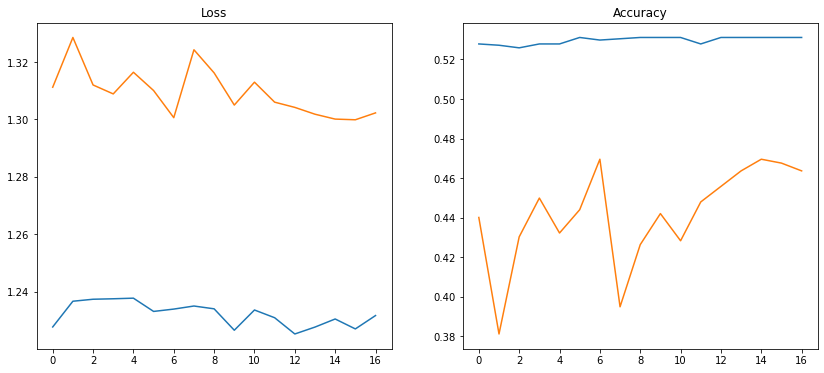

In [25]:
# plot loss and accuracy evolution
fig = plt.figure(figsize=(14,6))
ax1 = plt.subplot(121)
ax1.plot(range(len(results.history['loss'])),results.history['loss'])
ax1.plot(range(len(results.history['val_loss'])),results.history['val_loss'])
ax1.set_title('Loss')
ax2 = plt.subplot(122)
ax2.plot(range(len(results.history['acc'])),results.history['acc'])
ax2.plot(range(len(results.history['val_acc'])),results.history['val_acc'])
ax2.set_title('Accuracy')

In [26]:
# evaluation function
# Also from Gabe's lab 9.2!
def evaluate_models(models, histories, X_test, class_labels):
    '''
    Uses pre-compiled, pre-fit neural network classification models and their fit histories
    to generate useful statistics
    NOTE: assumes models were compiled with metrics including 'acc'

    Parameters:
    - models (list): list of pre-compiled, pre-fit models
    - histories (list): list of model histories - should be same length as models
    - X_test (array): test data of appropriate shape to make predictions on
    - class_labels (list): list of all possible class labels

    Displays:
    - Plots of confusion matrix, train/val loss over epochs, and test prediction counts

    Returns:
    - DataFrame containing model name, train/validation loss, train/validation accuracy
    '''

    assert type(models) == list
    assert type(histories) == list

    num_models = len(models)
    assert len(histories) == num_models

    model_stats = pd.DataFrame(columns = ['model_name', 'train_loss', 'val_loss', 'train_acc', 'val_acc'])

    fig = plt.figure(figsize = (20, num_models * 5.2))
    subfigs = fig.subfigures(num_models, wspace = 0.2, hspace = 0.2)
    if num_models == 1:
        subfigs = [subfigs]

    for i, model in enumerate(models):
        model_name = f'model {i}'

        train_loss = histories[i].history['loss']
        val_loss = histories[i].history['val_loss']
        train_acc = histories[i].history['acc']
        val_acc = histories[i].history['val_acc']

        # append our values to the stats dataframe
        model_stats.loc[len(model_stats)] = [model_name, train_loss[-1], val_loss[-1], train_acc[-1], val_acc[-1]]

        # display metrics
        # https://stackoverflow.com/questions/27426668/row-titles-for-matplotlib-subplot
        subfigs[i].suptitle(model_name)
        axs = subfigs[i].subplots(1, 3)

        # confusion matrix
        val_preds = np.array([np.argmax(x) for x in model.predict(X_test, verbose = 0)]).reshape(-1)
        true_preds = np.array([np.argmax(x) for x in y_test]).reshape(-1)
        axs[0].set_title('Confusion Matrix on Validation Set')
        ConfusionMatrixDisplay.from_predictions(true_preds, val_preds, display_labels = class_labels, ax = axs[0], xticks_rotation = 45)

        # performance of train vs val
        
        epoch_labels = histories[i].epoch
        axs[1].set_title(f'Loss by Epoch - Training vs. Validation')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel(model.loss)
        axs[1].set_xticks(epoch_labels, epoch_labels)
        axs[1].plot(train_loss, label = 'Training Loss', color = '#185fad')
        axs[1].plot(val_loss, label = 'Validation Loss', color = 'orange')
        axs[1].legend()
        
        # overview of test predictions
        test_class_probs = model.predict(X_test, batch_size = 128, verbose = 0)
        test_preds = [np.argmax(x) for x in test_class_probs]
        preds_df = pd.DataFrame([[class_labels[x], test_preds.count(x)]
            for x in set(test_preds)], columns = ['article', 'test_pred_count']).set_index('article')
        axs[2].set_title(f'Test Prediction Counts')
        preds_df.plot.barh(ax = axs[2])
        axs[2].get_legend().remove()

    return model_stats
        

In [27]:
models = []
histories = []

In [28]:
models.append(model)
histories.append(results)

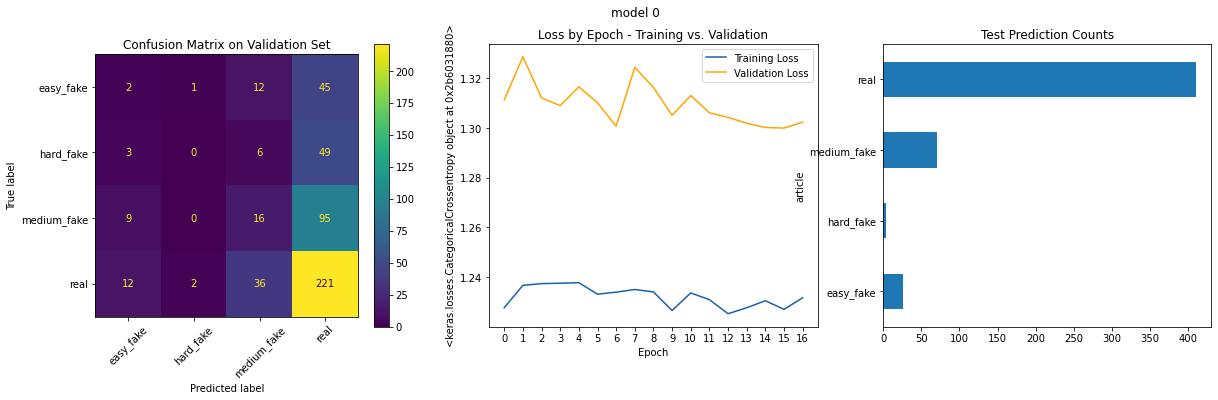

In [29]:
stats = evaluate_models(models, histories, X_test, class_labels)

##### Pretrained

In [21]:
input_shape = (Batch_Size,Image_Size, Image_Size,Channels)

In [26]:
pretrained_model = ResNet50V2(
    input_shape=(256,256,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable=False


In [8]:
def augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.95, 1.05)
    image = tf.image.random_brightness(image, 0.1)
    tf.image.adjust_hue
    # image = tf.image.random_crop(image, (200, 200, 3))
    # image = tf.image.resize(image, (image_size, image_size))
    return image

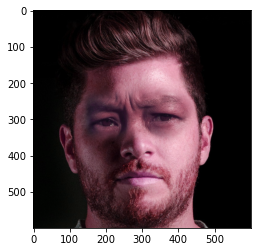

In [35]:
plt.imshow(tf.image.adjust_hue(X_train[23],0.9))

In [37]:
tf.image.sobel_edges(X_train[10])
        # ax[3][i].imshow(sobel[0, ..., 0].numpy().astype("uint8"))
        # ax[3][i].set_title("sobel y")
        # # sobel edge
        # ax[4][i].imshow(sobel[0, ..., 1].numpy().astype("uint8"))
        # ax[4][i].set_title("sobel x")

AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'

In [38]:
sobel= tf.image.sobel_edges(X_train[10])
print(sobel.shape)
cv2.imshow("image", image)
sobel_x = np.asarray(sobel[0, :, :, :, 0])  #  Sobel_X
sobel_y = np.asarray(sobel[0, :, :, :, 1])  #  Sobel_Y
cv2.imshow("Sobel_x",sobel_x)
cv2.imshow("Sobel_y",sobel_y)
cv2.waitKey(0)

AttributeError: 'numpy.ndarray' object has no attribute 'get_shape'

In [9]:
X_train_au=[augment(image) for image in X_train]

In [28]:
model_trans_h=Sequential()
model_trans_h.add(pretrained_model)
# model_trans_h.add(Flatten())
# model_trans_h.add(RandomFlip())
# model_trans_h.add(RandomContrast(.95,1.05))
# model_trans_h.add(RandomBrightness(.1))
# model_trans_h.add(RandomCrop(550,550,3))
model_trans_h.add(Dense(128,activation="relu"))
model_trans_h.add(Dropout(0.3))
model_trans_h.add(Dense(64,activation="relu"))
model_trans_h.add(Dropout(0.3))
model_trans_h.add(Dense(1,activation="sigmoid"))

model_trans_h.compile(loss="binary_crossentropy",optimizer='adam',metrics=['binary_accuracy'])
history_cnn_trans_h=model_trans_h.fit(train_ds,batch_size=16,validation_data=val_ds,epochs=30,verbose=1)


Epoch 1/30


2022-11-07 13:43:53.278025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - ETA: 0s - loss: 17.2227 - binary_accuracy: 0.5067

2022-11-07 13:44:01.966511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 18s 306ms/step - loss: 17.2227 - binary_accuracy: 0.5067 - val_loss: 1.6091 - val_binary_accuracy: 0.4933
Epoch 2/30
51/51 [==============================] - 14s 279ms/step - loss: 2.6433 - binary_accuracy: 0.5331 - val_loss: 0.9433 - val_binary_accuracy: 0.5466
Epoch 3/30
51/51 [==============================] - 14s 278ms/step - loss: 1.3028 - binary_accuracy: 0.4988 - val_loss: 0.6931 - val_binary_accuracy: 0.4773
Epoch 4/30
51/51 [==============================] - 14s 279ms/step - loss: 0.6919 - binary_accuracy: 0.5276 - val_loss: 0.6913 - val_binary_accuracy: 0.5349
Epoch 5/30
51/51 [==============================] - 14s 278ms/step - loss: 0.6905 - binary_accuracy: 0.5343 - val_loss: 0.6909 - val_binary_accuracy: 0.5349
Epoch 6/30
51/51 [==============================] - 15s 292ms/step - loss: 0.6908 - binary_accuracy: 0.5355 - val_loss: 0.6902 - val_binary_accuracy: 0.5349
Epoch 7/30
51/51 [==============================] - 15s 301ms/step -

KeyboardInterrupt: 

2022-11-05 21:23:00.740828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 18s 907ms/step


([3,
  4,
  11,
  31,
  42,
  77,
  83,
  87,
  95,
  96,
  102,
  107,
  109,
  111,
  125,
  133,
  138,
  164,
  176,
  179,
  186,
  190,
  203,
  224,
  249,
  252,
  265,
  278,
  299,
  305,
  316,
  320,
  321,
  345,
  368,
  374,
  381,
  418,
  423,
  424,
  441,
  462,
  463,
  464,
  470,
  476,
  479,
  486,
  501,
  507],
 [1,
  10,
  35,
  38,
  40,
  41,
  46,
  59,
  65,
  70,
  74,
  75,
  78,
  90,
  94,
  100,
  116,
  120,
  121,
  139,
  152,
  157,
  161,
  173,
  184,
  198,
  202,
  220,
  222,
  227,
  242,
  243,
  247,
  253,
  254,
  258,
  261,
  276,
  290,
  297,
  322,
  326,
  338,
  344,
  348,
  349,
  357,
  372,
  378,
  383,
  398,
  414,
  417,
  429,
  431,
  433,
  448,
  452,
  465,
  466,
  468,
  469,
  488,
  494,
  506],
 <Figure size 1440x1440 with 14 Axes>)

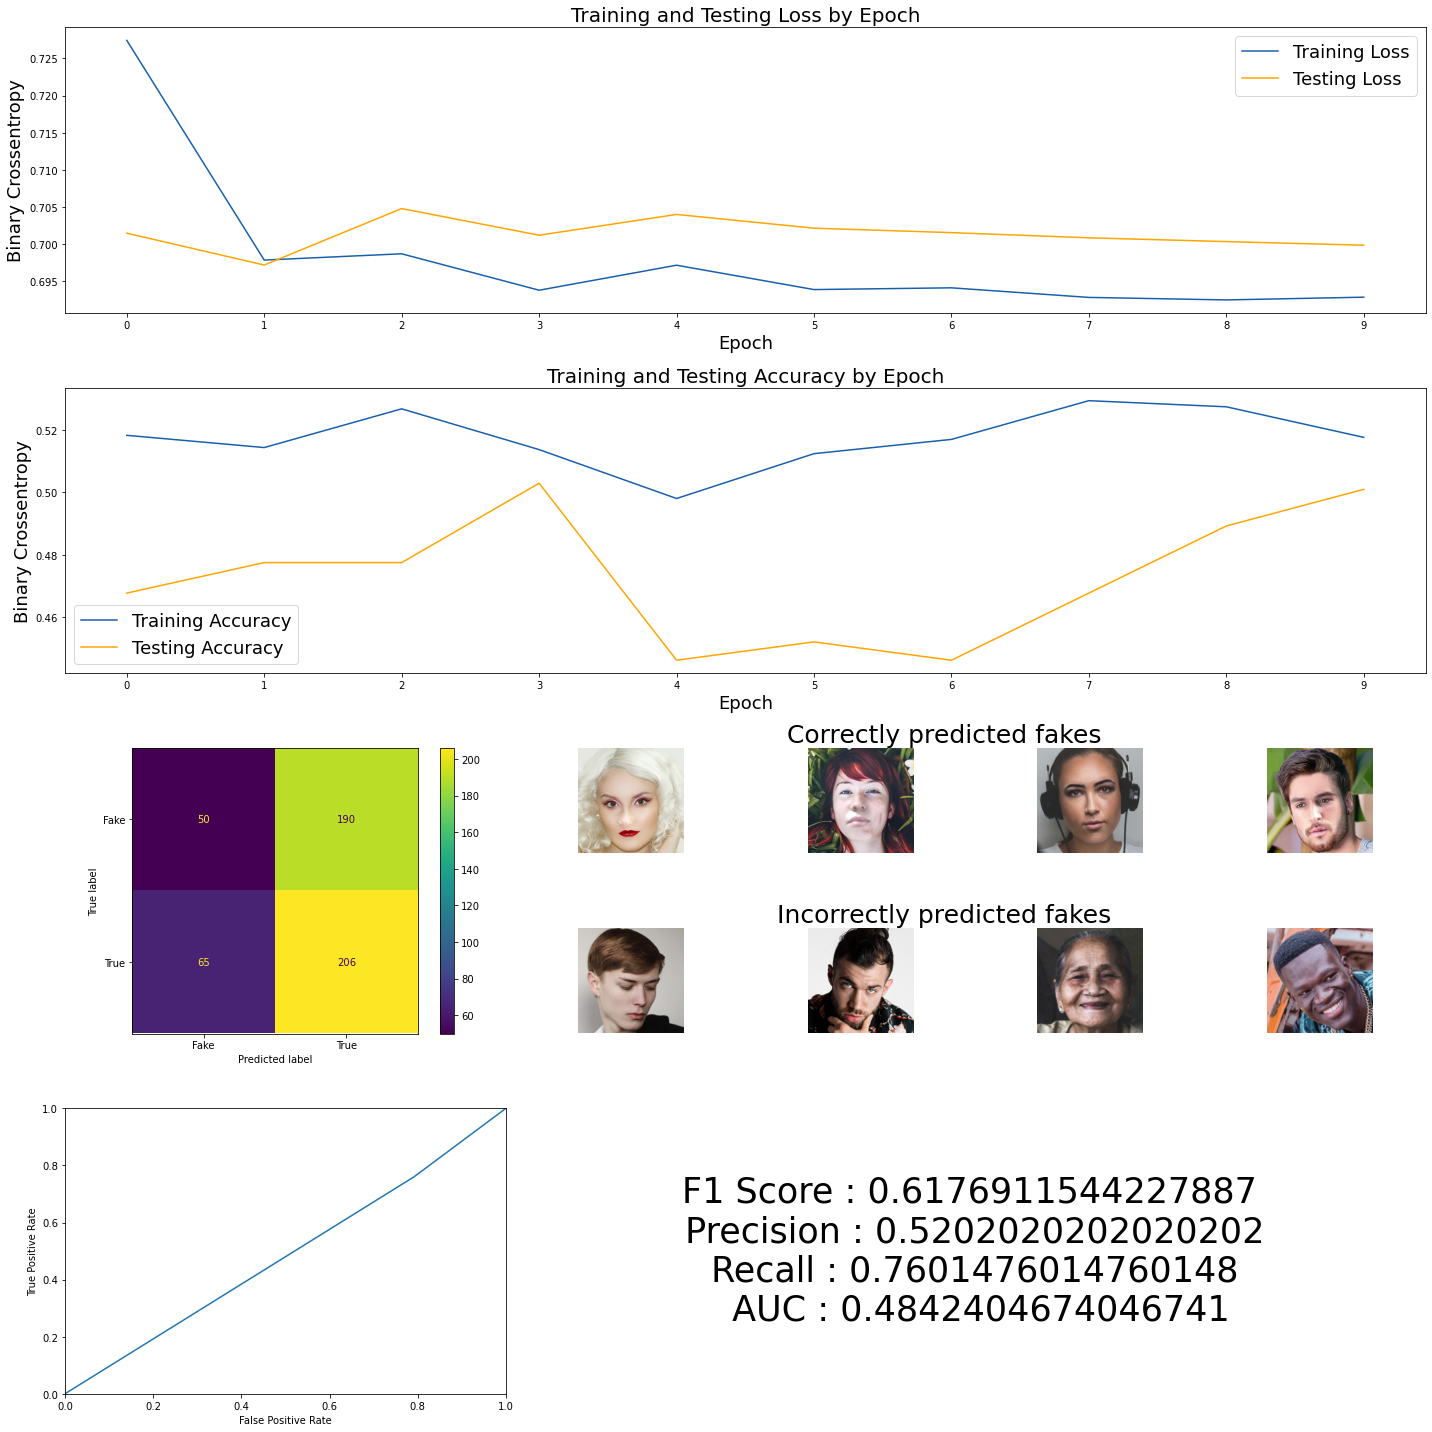

In [34]:
Universal().plot_results_duo(history_cnn_trans_h,model_trans_h,X_test,y_test)

----

In [5]:
true_faces=Universal().get_class(X_train,y_train,1)
fake_faces=Universal().get_class(X_train,y_train,0)

In [6]:
samples=np.concatenate((true_faces[:10],fake_faces[:10]))

In [7]:
samples.shape

(20, 600, 600, 3)

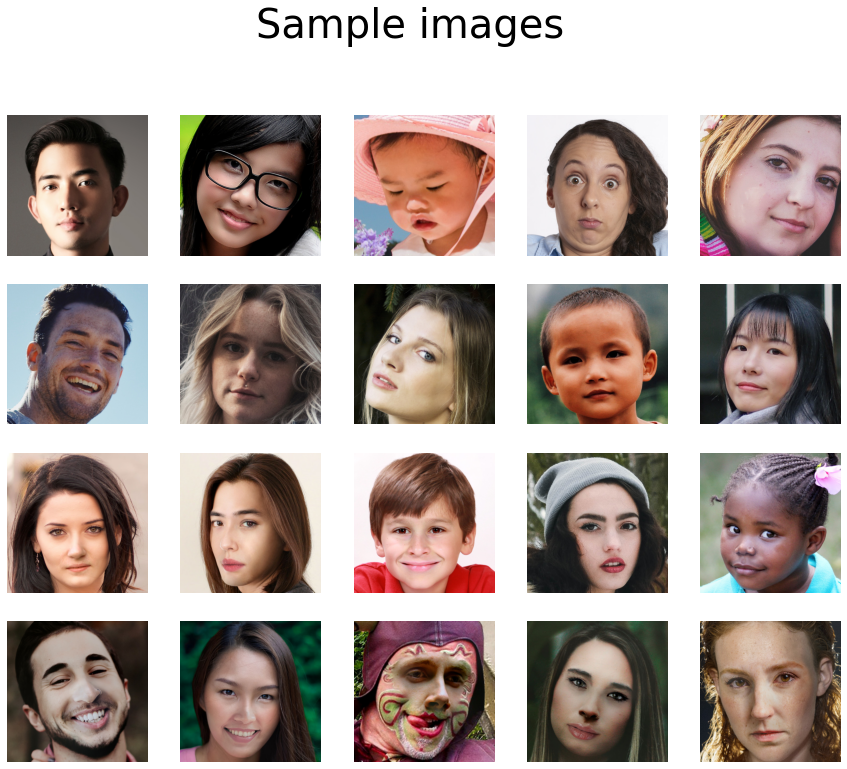

In [8]:
Universal().plot_samples(samples,20,5,"Sample");

In [9]:
rgb_img = samples[10]
hsv_img = rgb2hsv(rgb_img)
hue_img = hsv_img[:, :, 0]
value_img = hsv_img[:, :, 2]

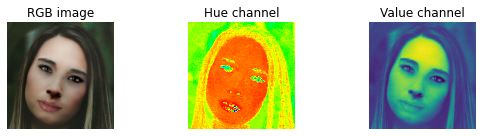

In [10]:
rgb_img = samples[18]
hsv_img = rgb2hsv(rgb_img)
hue_img = hsv_img[:, :, 0]
value_img = hsv_img[:, :, 2]

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(8, 2))

ax0.imshow(rgb_img)
ax0.set_title("RGB image")
ax0.axis('off')
ax1.imshow(hue_img, cmap='hsv')
ax1.set_title("Hue channel")
ax1.axis('off')
ax2.imshow(value_img)
ax2.set_title("Value channel")
ax2.axis('off')

fig.tight_layout()

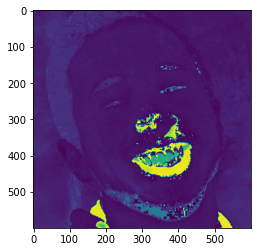

In [11]:
hsv_img_2 = rgb2hsv(samples[15])
hue_img = hsv_img_2[:, :, 0]
plt.imshow(hue_img)

In [12]:
X_hue=np.zeros(shape=(X.shape[0],600,600))
for c,x in enumerate(X):
    hsv_im = rgb2hsv(x)
    hue_img = hsv_im[:, :, 0]
    X_hue[c]=hue_img




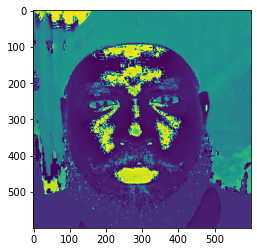

In [13]:
plt.imshow(X_hue[1])

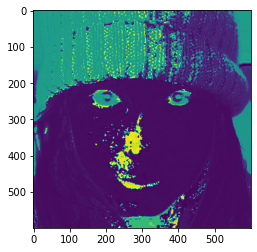

In [14]:
plt.imshow(X_hue[2])

In [15]:
X_train_h,X_test_h,y_train_h,y_test_h=train_test_split(X_hue,y,random_state=42,stratify=y)
X_train_h.shape,y_train_h.shape, X_test_h.shape,y_test_h.shape

((1530, 600, 600), (1530,), (511, 600, 600), (511,))

In [16]:
pretrained_model = VGG19(input_shape=[600,600,1], include_top=False)
pretrained_model.trainable = False
# pretrained_model_eff_net = EfficientNetB7(include_top=False, weights='imagenet',input_shape=(600,600,3))
# pretrained_model_eff_net.trainable=False

ValueError: The input must have 3 channels; Received `input_shape=[600, 600, 1]`

In [18]:
model_trans_h=Sequential()
model_trans_h.add(pretrained_model)
model_trans_h.add(Flatten())

model_trans_h.add(Dense(128,activation="relu"))
model_trans_h.add(Dense(64,activation="relu"))
model_trans_h.add(Dense(1,activation="sigmoid"))
model_trans_h.compile(loss="binary_crossentropy",optimizer='adam',metrics=['acc'])
history_cnn_trans_h=model_trans_h.fit(X_train_h,y_train_h,batch_size=16,validation_data=(X_test_h,y_test_h),epochs=10,verbose=1)


Epoch 1/10


2022-11-04 16:12:04.543495: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ValueError: in user code:

    File "/Users/glebradchenko/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/glebradchenko/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/glebradchenko/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/glebradchenko/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/Users/glebradchenko/opt/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "normalization" "                 f"(type Normalization).
    
    Dimensions must be equal, but are 600 and 3 for '{{node sequential/efficientnetb7/normalization/sub}} = Sub[T=DT_FLOAT](sequential/efficientnetb7/rescaling/add, sequential/efficientnetb7/normalization/sub/y)' with input shapes: [?,600,600], [1,1,1,3].
    
    Call arguments received by layer "normalization" "                 f"(type Normalization):
      • inputs=tf.Tensor(shape=(None, 600, 600), dtype=float32)


: 

In [28]:
# model 0
# very simple CNN
model_hue = Sequential()
model_hue.add(Conv2D(filters = 8, kernel_size = (6, 6), activation = 'relu', input_shape = (600, 600,1)))
model_hue.add(MaxPooling2D(pool_size = (3, 3)))
model_hue.add(Conv2D(filters = 8, kernel_size = (6, 6), activation = 'relu'))
model_hue.add(MaxPooling2D(pool_size = (2, 2)))
model_hue.add(Flatten())
model_hue.add(Dense(64, activation = 'relu'))
model_hue.add(Dense(1, activation = 'sigmoid'))

model_hue.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])
history_hue = model_hue.fit(X_train_h, y_train, batch_size = 64, epochs = 10, verbose = 1, validation_data = (X_test_h, y_test))



Epoch 1/10


2022-11-04 16:23:28.301481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - ETA: 0s - loss: 0.7142 - acc: 0.5379

2022-11-04 16:23:44.225128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 18s 708ms/step - loss: 0.7142 - acc: 0.5379 - val_loss: 0.6921 - val_acc: 0.5303
Epoch 2/10
24/24 [==============================] - 13s 539ms/step - loss: 0.6782 - acc: 0.5608 - val_loss: 0.6827 - val_acc: 0.5479
Epoch 3/10
24/24 [==============================] - 12s 521ms/step - loss: 0.5648 - acc: 0.7255 - val_loss: 0.7719 - val_acc: 0.5205
Epoch 4/10
24/24 [==============================] - 12s 513ms/step - loss: 0.2788 - acc: 0.9098 - val_loss: 1.0246 - val_acc: 0.5440
Epoch 5/10
24/24 [==============================] - 12s 510ms/step - loss: 0.0908 - acc: 0.9784 - val_loss: 1.3618 - val_acc: 0.5245
Epoch 6/10
24/24 [==============================] - 12s 512ms/step - loss: 0.0325 - acc: 0.9980 - val_loss: 1.7173 - val_acc: 0.5303
Epoch 7/10
24/24 [==============================] - 12s 514ms/step - loss: 0.0131 - acc: 0.9987 - val_loss: 2.1155 - val_acc: 0.5460
Epoch 8/10
24/24 [==============================] - 12s 511ms/step - loss: 0.006

16/16 [==============================] - 1s 74ms/step


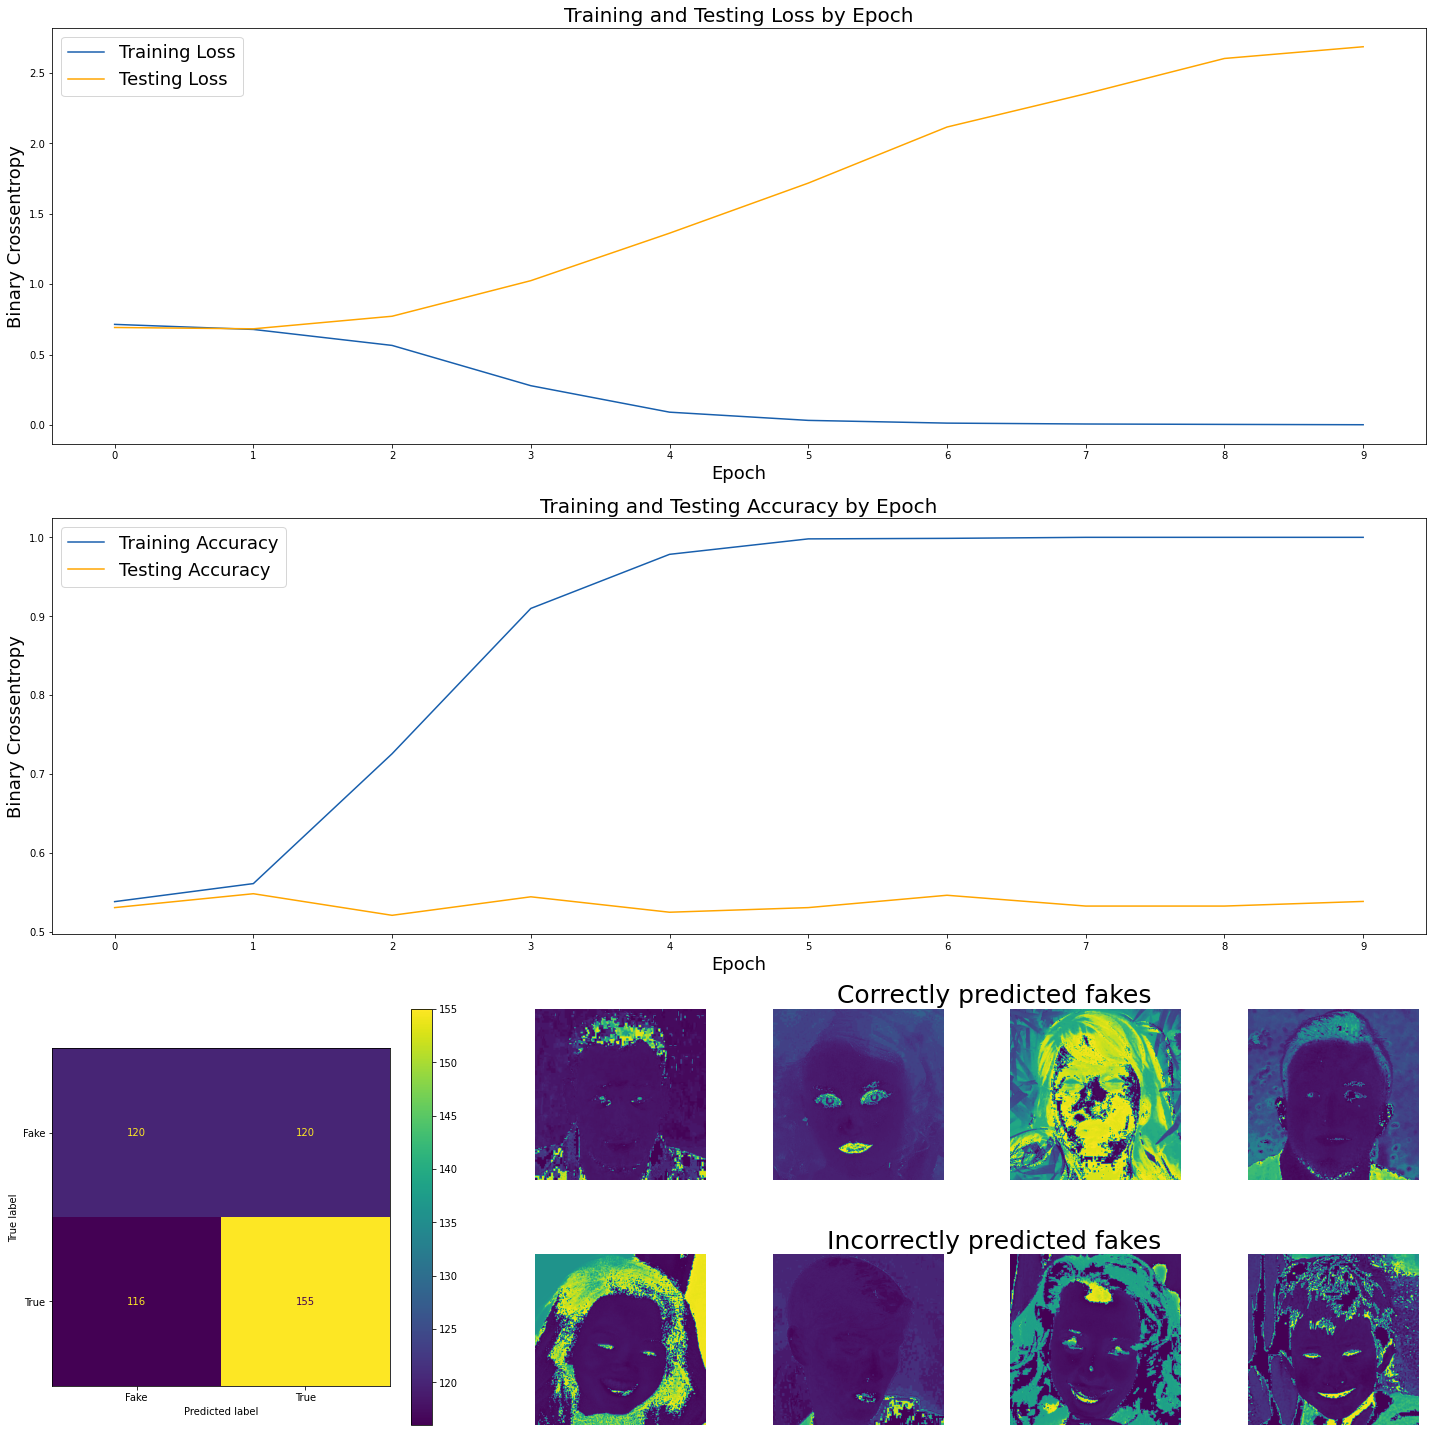

In [162]:
Universal().plot_results_duo(history_hue,model_hue,X_test_h,y_test);

In [166]:
preds=(model_hue.predict(X_test_h)>0.5).astype(int)
mismatches = [i for i in range(0, len(preds)) if preds[i] != y_test_h[i]]
matches = [i for i in range(0, len(preds)) if preds[i]==0 and y_test_h[i]==0]


16/16 [==============================] - 1s 83ms/step


1/1 [==============================] - 0s 121ms/step


2022-11-04 19:36:35.101595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


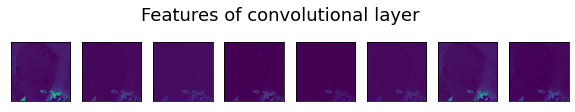

In [167]:
Universal().get_feat(model_hue,X_test_h[mismatches[1]],layer_num=0);

1/1 [==============================] - 0s 101ms/step


2022-11-04 19:36:37.766245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


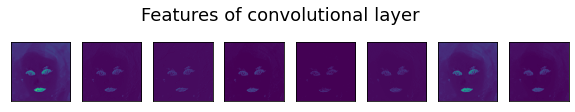

In [168]:
Universal().get_feat(model_hue,X_test_h[matches[1]],layer_num=0);

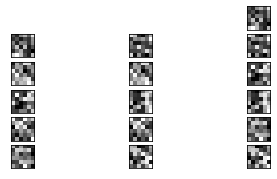

In [234]:
Universal().get_filters(model_hue,2)

In [ ]:

size_n = 5 # NxN neighborhood around each pixel

# Read input image
img = samples[10]

# Convert to LAB color space
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# Get the L channel
L = lab[:, :, 0]

# Use "dilate" morphological operation (dilate is equivalent to finding maximum pixel in NxN neighborhood)
img_max = cv2.morphologyEx(L, cv2.MORPH_DILATE, np.ones((size_n, size_n)))

# Use "erode" morphological operation (dilate is equivalent to finding maximum pixel in NxN neighborhood)
img_min = cv2.morphologyEx(L, cv2.MORPH_ERODE, np.ones((size_n, size_n)))

# Convert to type float (required before using division operation)
img_max = img_max.astype(float)
img_min = img_min.astype(float)

# Compute contrast map (range of img_contrast is [0, 1])
img_contrast = (img_max - img_min) / (img_max + img_min)

# Convert contrast map to type uint8 with rounding - the conversion loosed accuracy, so I can't recommend it.
# Note: img_contrast_uint8 is scaled by 255 (scaled by 255 relative to the original formula).
img_contrast_uint8 = np.round(img_contrast*255).astype(np.uint8)

# Show img_contrast as output
cv2.imshow('img_contrast', img_contrast_uint8)
cv2.waitKey()
cv2.destroyAllWindows()


In [ ]:
img=samples[9]
plt.imshow(img)

In [ ]:
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
L = lab[:, :, 0]

plt.imshow(lab)


In [ ]:
size_n = 5
img_max = cv2.morphologyEx(L, cv2.MORPH_DILATE, np.ones((size_n, size_n)))
plt.imshow(img_max)


In [ ]:
img_min = cv2.morphologyEx(L, cv2.MORPH_ERODE, np.ones((size_n, size_n)))
plt.imshow(img_min)


In [ ]:
img_max = img_max.astype(float)
img_min = img_min.astype(float)
img_contrast = (img_max - img_min) / (img_max + img_min)
plt.imshow(img_contrast)


In [ ]:
img_contrast_uint8 = np.round(img_contrast*255).astype(np.uint8)
plt.imshow(img_contrast_uint8)


In [ ]:
dif=samples[9]

In [ ]:
hue_threshold = 0.05
binary_img = hue_img > hue_threshold

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))

ax0.hist(hue_img.ravel(), 512)
ax0.set_title("Histogram of the Hue channel with threshold")
ax0.axvline(x=hue_threshold, color='r', linestyle='dashed', linewidth=2)
ax0.set_xbound(0, 0.12)
ax1.imshow(binary_img)
ax1.set_title("Hue-thresholded image")
ax1.axis('off')

fig.tight_layout()

In [ ]:
fig, ax0 = plt.subplots(figsize=(4, 3))

value_threshold = 0.10
binary_img = (hue_img > hue_threshold) | (value_img < value_threshold)

ax0.imshow(binary_img)
ax0.set_title("Hue and value thresholded image")
ax0.axis('off')

fig.tight_layout()
plt.show()

In [ ]:
import matplotlib

from skimage import data, img_as_float
from skimage import exposure

matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = samples[10]

# Gamma
gamma_corrected = exposure.adjust_gamma(img, 4)

# Logarithmic
logarithmic_corrected = exposure.adjust_log(img, 1)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(gamma_corrected, axes[:, 1])
ax_img.set_title('Gamma correction')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(logarithmic_corrected, axes[:, 2])
ax_img.set_title('Logarithmic correction')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [ ]:
import matplotlib

from skimage import data, img_as_float
from skimage import exposure

matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = samples[11]

# Gamma
gamma_corrected = exposure.adjust_gamma(img, 4)

# Logarithmic
logarithmic_corrected = exposure.adjust_log(img, 1)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(gamma_corrected, axes[:, 1])
ax_img.set_title('Gamma correction')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(logarithmic_corrected, axes[:, 2])
ax_img.set_title('Logarithmic correction')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [ ]:
from skimage import measure


# Construct some test data
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
# r = np.sin(np.exp((np.sin(x)**3 + np.cos(y)**2)))
r=samples[[10]]
# Find contours at a constant value of 0.8
contours = measure.find_contours(r, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
plt.imshow(r)


In [ ]:
from skimage.util import random_noise
from skimage import feature

In [ ]:
img_noise= random_noise(samples[11],mode='gaussian',seed=42,mean=0.4)
plt.imshow(img_noise)

In [ ]:
import pywt



# Load image
original = samples[13]

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs2 = pywt.dwt2(original, 'bior1.3')
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 6))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [ ]:
plt.imshow(LH)

In [ ]:
plt.imshow(rgb_img)

In [ ]:
plt.imshow(hsv_img)

In [ ]:
plot_samples(hsv_img,20,5);

In [ ]:
hue_threshold = 0.04
binary_img = hue_img > hue_threshold

Add EDA
Try on different augumentations
Try on different model if succesfull
Try on prelearned model in the end to compare results
Write readme file

Try with different type of fake images (deepfakes).
